# Simulation-based inference with ACE
## SIR task

To run this evaluation notebook, please move the notebook to the outside folder under `amortized-conditioning-engine/`, we saved the trained models under `results/sir` for standard task and `results/sir_pi` for ACE with prior injection.

In [2]:
import sys
import os

import hydra
import matplotlib.pyplot as plt
import torch
from torch.distributions import Uniform, Binomial, LogNormal
from hydra import initialize, compose
from src.model.base import BaseTransformer
from src.dataset.sampler_joint import Sampler
from src.dataset.sampler_twoway import Sampler as Sampler_base
from src.dataset.sbi.sir import SIR, SIROnline, SIROnlineAll, SIROnlineSamePrior

import pickle
import seaborn as sns
import sbi
from sbi.utils.torchutils import *
from sbi.utils import process_prior
from sbi.utils.user_input_checks import *
from sbi_demo_utils import *
from attrdict import AttrDict
import pandas as pd
from scipy.interpolate import make_interp_spline, BSpline
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

update_plot_style()

plt.rcParams['text.latex.preamble'] = r'\usepackage{times}'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
class SIR_npe(object):
    def __init__(self, total_count=1000, T=160):
        self.prior = [Uniform(0.01 * torch.ones(1), 1.5 * torch.ones(1)),
                     Uniform(0.02 * torch.ones(1), 0.25 * torch.ones(1))]
        self.total_count = total_count  # The maximum number of samples for binomial sampling
        self.T = T  # The total number of time steps

    def sample_theta(self, size):
        beta = self.prior[0].sample(size).reshape(-1, 1)
        gamma = self.prior[1].sample(size).reshape(-1, 1)
        
        return torch.cat([beta, gamma], dim=1)

    def __call__(self, thetas):
        beta = thetas[0]
        gamma = thetas[1]
        S0, I0, R0 = 999999, 1, 0  # Initial conditions

        N_total = S0 + I0 + R0

        S = torch.zeros(self.T)
        I = torch.zeros(self.T)
        R = torch.zeros(self.T)

        S[0], I[0], R[0] = S0, I0, R0

        # Simulate the SIR model dynamics
        for t in range(1, self.T):
            new_infections = beta * S[t - 1] * I[t - 1] / N_total
            new_recoveries = gamma * I[t - 1]

            S[t] = S[t - 1] - new_infections
            I[t] = I[t - 1] + new_infections - new_recoveries
            R[t] = R[t - 1] + new_recoveries

        num_bins = max(1, self.T // 10 + 1)
        # Subsample the data, only keep a subset of the infection data
        I_subsampled = I[::num_bins]  # Subsampling every `num_bins` steps

        I_subsampled = torch.where(I_subsampled < 0, torch.zeros_like(I_subsampled), I_subsampled)
        I_subsampled = torch.where(torch.isnan(I_subsampled), torch.zeros_like(I_subsampled), I_subsampled)

        I_sampled = Binomial(self.total_count, I_subsampled / N_total).sample()

        X = I_sampled / 1000

        return X

In [4]:
path = "results/sir/"
cfg_twoway, model_twoway = load_config_and_model(path=path, ckpt_name="ckpt_1.tar")

In [5]:
batch_size = 20
dataset = SIR(x_file="data/x_sir_10000.pt",
              theta_file="data/theta_sir_10000.pt",
              order="fixed",
              batch_size=batch_size)

num_ctx_for_ppd = 5

# define sampler
sampler = Sampler_base(problem=dataset, 
                       batch_size=batch_size,
                       num_ctx=10,
                       num_latent=2, 
                       min_num_points=num_ctx_for_ppd, 
                       max_num_points=num_ctx_for_ppd+1,
                       n_total_points=12,
                       ctx_tar_sampler="predict_latents_fixed")

eval_set = sampler.sample()

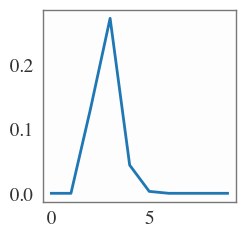

In [6]:
seed = 2
plt.plot(eval_set.xc[seed, :, 1], eval_set.yc[seed, :, 0] )
plt.show()

# Final evaluation

In [20]:
x_npe = torch.load("data/x_sir_10000.pt")
theta_npe = torch.load("data/theta_sir_10000.pt")

simulator = SIR_npe()
prior = simulator.prior
prior, *_ = process_prior(prior)

# train 5 NPE
posterior_npe = []
for seed in range(1):
    posterior_npe.append(train_npe(prior, theta_npe, x_npe))

# train 5 NRE
posterior_nre = []
for seed in range(5):
    posterior_nre.append(train_nre(prior, theta_npe, x_npe))

# save trained NPE and NRE
save_dir = "data/npe_posteriors_sir"
for i, posterior in enumerate(posterior_npe):
    save_path = os.path.join(save_dir, f"posterior_npe_{i}.pkl")
    with open(save_path, "wb") as handle:
        pickle.dump(posterior, handle)

save_dir = "data/nre_posteriors_sir"
for i, posterior in enumerate(posterior_nre):
    save_path = os.path.join(save_dir, f"posterior_nre_{i}.pkl")
    with open(save_path, "wb") as handle:
        pickle.dump(posterior, handle)

 Training neural network. Epochs trained: 101

In [7]:
# load trained NPE and NRE
save_dir = "data/npe_posteriors_sir"
posterior_npe = []
for i in range(5):
    load_path = os.path.join(save_dir, f"posterior_npe_{i}.pkl")
    with open(load_path, "rb") as handle:
        posterior_npe.append(pickle.load(handle))

save_dir = "data/nre_posteriors_sir"
posterior_nre = []
for i in range(5):
    load_path = os.path.join(save_dir, f"posterior_nre_{i}.pkl")
    with open(load_path, "rb") as handle:
        posterior_nre.append(pickle.load(handle))

## Evaluation of latents

In [8]:
n_runs = 5
batch_size = 100
dataset = SIROnlineAll(order="fixed")

num_ctx_for_ppd = 5

# define sampler
sampler_joint = Sampler(problem=dataset, 
                        batch_size=batch_size,
                        num_latent=2, 
                        min_num_points=num_ctx_for_ppd, 
                        max_num_points=num_ctx_for_ppd+1)

eval_set_oneway, eval_set_twoway, eval_set_pi_twoway_narrow, eval_set_pi_twoway_wide = sampler_joint.sample_all_bin()

In [87]:
# save eval sets for posterior inference
data_dir = "data/eval_sets_sir"

torch.save(eval_set_oneway, os.path.join(data_dir, "eval_set_oneway.pt"))
torch.save(eval_set_twoway, os.path.join(data_dir, "eval_set_twoway.pt"))
torch.save(eval_set_pi_twoway_narrow, os.path.join(data_dir, "eval_set_pi_twoway_narrow.pt"))
torch.save(eval_set_pi_twoway_wide, os.path.join(data_dir, "eval_set_pi_twoway_wide.pt"))

In [9]:
# load eval sets for posterior inference
data_dir = "data/eval_sets_sir"

eval_set_oneway = torch.load(os.path.join(data_dir, "eval_set_oneway.pt"))
eval_set_twoway = torch.load(os.path.join(data_dir, "eval_set_twoway.pt"))
eval_set_pi_twoway_narrow = torch.load(os.path.join(data_dir, "eval_set_pi_twoway_narrow.pt"))
eval_set_pi_twoway_wide = torch.load(os.path.join(data_dir, "eval_set_pi_twoway_wide.pt"))

In [10]:
n_runs = 5

# go first with NPE as it takes some time
all_log_probs_npe = np.zeros(5)
all_rmse_npe = np.zeros(5)

for seed in range(n_runs):
    
    log_probs_npe = torch.zeros([batch_size])
    for i in range(batch_size):
        log_probs_npe[i] = posterior_npe[seed].log_prob(theta=eval_set_oneway.yt[i].reshape(-1, 2), x=eval_set_oneway.yc[i].reshape(-1, 10))
    all_log_probs_npe[seed] = log_probs_npe.mean().numpy()

    rmse_npe = torch.zeros([batch_size])
    samples_npe_all = torch.empty([batch_size, 2, 200])
    for i in range(batch_size):
        samples_npe_all[i] = posterior_npe[seed].sample((200,), x=eval_set_oneway.yc[i].reshape(-1, 10), show_progress_bars=False).T
    all_rmse_npe[seed] = RMSE(eval_set_oneway.yt, samples_npe_all)

print(f"NPE Log probs mean: {all_log_probs_npe.mean().item()}")
print(f"NPE Log probs std: {all_log_probs_npe.std().item()}")

print(f"NPE RMSE mean: {all_rmse_npe.mean().item()}")
print(f"NPE RMSE std: {all_rmse_npe.std().item()}")

NPE Log probs mean: 6.52683687210083
NPE Log probs std: 0.1067903460604361
NPE RMSE mean: 0.02395510785281658
NPE RMSE std: 0.0005961892939571067


In [12]:
n_runs = 5

# go first with NRE as it takes some time
all_log_probs_nre = np.zeros(5)
all_rmse_nre = np.zeros(5)

for seed in range(n_runs):
    
    log_probs_nre = torch.zeros([batch_size])
    for i in range(batch_size):
        log_probs_nre[i] = posterior_nre[seed].log_prob(theta=eval_set_oneway.yt[i].reshape(-1, 2), x=eval_set_oneway.yc[i].reshape(-1, 10))
    all_log_probs_nre[seed] = log_probs_nre.mean().numpy()

    rmse_npe = torch.zeros([batch_size])
    samples_nre_all = torch.empty([batch_size, 2, 100])
    for i in range(batch_size):
        samples_nre_all[i] = posterior_nre[seed].sample((100,), x=eval_set_oneway.yc[i].reshape(-1, 10), show_progress_bars=False).T
    all_rmse_nre[seed] = RMSE(eval_set_oneway.yt, samples_nre_all)

print(f"NRE Log probs mean: {all_log_probs_nre.mean().item()}")
print(f"NRE Log probs std: {all_log_probs_nre.std().item()}")

print(f"NRE RMSE mean: {all_rmse_nre.mean().item()}")
print(f"NRE RMSE std: {all_rmse_nre.std().item()}")

NRE Log probs mean: 6.2398193359375
NRE Log probs std: 0.1613214124891001
NRE RMSE mean: 0.030018803477287293
NRE RMSE std: 0.0030554746456341753


In [11]:
all_log_probs_ace = np.zeros(5)
all_log_probs_ace_pi_narrow = np.zeros(5)
all_log_probs_ace_pi_wide = np.zeros(5)

all_rmse_ace= np.zeros(5)
all_rmse_ace_pi_narrow = np.zeros(5)
all_rmse_ace_pi_wide = np.zeros(5)

for seed in range(n_runs):
    # two way baseline
    path = "results/sir/"
    cfg_twoway, model_twoway = load_config_and_model(path, "config.yaml", f"ckpt_{seed+1}.tar")
    out_twoway = model_twoway.forward(eval_set_twoway, predict=True)
    samples_twoway = out_twoway.samples
    log_probs_twoway = -out_twoway.losses.sum(dim=-1)
    all_log_probs_ace[seed] = log_probs_twoway.mean().detach().numpy()
    all_rmse_ace[seed] = RMSE(eval_set_oneway.yt, samples_twoway)
    
    
    # two way prior injection narrow
    path = "results/sir_pi/"
    cfg_twoway_pi, model_twoway_pi = load_config_and_model(path, "config.yaml", f"ckpt_{seed+1}.tar")
    out_twoway_pi_narrow = model_twoway_pi.forward(eval_set_pi_twoway_narrow, predict=True)
    samples_twoway_pi_narrow = out_twoway_pi_narrow.samples
    log_probs_twoway_pi_narrow = -out_twoway_pi_narrow.losses.sum(dim=-1)
    all_log_probs_ace_pi_narrow[seed] = log_probs_twoway_pi_narrow.mean().detach().numpy()
    all_rmse_ace_pi_narrow[seed] = RMSE(eval_set_oneway.yt, samples_twoway_pi_narrow)

    # two way prior injection wide
    out_twoway_pi_wide = model_twoway_pi.forward(eval_set_pi_twoway_wide, predict=True)
    samples_twoway_pi_wide = out_twoway_pi_wide.samples
    log_probs_twoway_pi_wide = -out_twoway_pi_wide.losses.sum(dim=-1)
    all_log_probs_ace_pi_wide[seed] = log_probs_twoway_pi_wide.mean().detach().numpy()
    all_rmse_ace_pi_wide[seed] = RMSE(eval_set_oneway.yt, samples_twoway_pi_wide)

print(f"ACE Log probs mean: {all_log_probs_ace.mean().item()}")
print(f"ACE Log probs std: {all_log_probs_ace.std().item()}")
print(f"ACE RMSE mean: {all_rmse_ace.mean().item()}")
print(f"ACE RMSE std: {all_rmse_ace.std().item()}")

print(f"ACE PI wide Log probs mean: {all_log_probs_ace_pi_wide.mean().item()}")
print(f"ACE PI wide Log probs std: {all_log_probs_ace_pi_wide.std().item()}")
print(f"ACE PI wide RMSE mean: {all_rmse_ace_pi_wide.mean().item()}")
print(f"ACE PI wide RMSE std: {all_rmse_ace_pi_wide.std().item()}")

print(f"ACE PI narrow Log probs mean: {all_log_probs_ace_pi_narrow.mean().item()}")
print(f"ACE PI narrow Log probs std: {all_log_probs_ace_pi_narrow.std().item()}")
print(f"ACE PI narrow RMSE mean: {all_rmse_ace_pi_narrow.mean().item()}")
print(f"ACE PI narrow RMSE std: {all_rmse_ace_pi_narrow.std().item()}")

ACE Log probs mean: 6.77625732421875
ACE Log probs std: 0.015664397391029844
ACE RMSE mean: 0.0208793543279171
ACE RMSE std: 0.00019869876860787347
ACE PI wide Log probs mean: 6.615552234649658
ACE PI wide Log probs std: 0.09752091411045581
ACE PI wide RMSE mean: 0.020752278715372087
ACE PI wide RMSE std: 0.0006810734078813655
ACE PI narrow Log probs mean: 6.691895771026611
ACE PI narrow Log probs std: 0.10288250544332034
ACE PI narrow RMSE mean: 0.01893892027437687
ACE PI narrow RMSE std: 0.0006975083339999629


In [14]:
n_runs=5

all_log_probs_ace = np.zeros(5)

all_rmse_ace= np.zeros(5)

for seed in range(n_runs):
    # two way baseline
    path = "results/sir_gaussian_head/"
    cfg_twoway, model_twoway = load_config_and_model(path, "config.yaml", f"ckpt_{seed+1}.tar")
    out_twoway = model_twoway.forward(eval_set_twoway, predict=True)
    samples_twoway = out_twoway.samples.squeeze(-1)
    log_probs_twoway = -out_twoway.losses.sum(dim=-1)
    all_log_probs_ace[seed] = log_probs_twoway.mean().detach().numpy()
    all_rmse_ace[seed] = RMSE(eval_set_oneway.yt, samples_twoway)

print(f"ACE Log probs mean: {all_log_probs_ace.mean().item()}")
print(f"ACE Log probs std: {all_log_probs_ace.std().item()}")
print(f"ACE RMSE mean: {all_rmse_ace.mean().item()}")
print(f"ACE RMSE std: {all_rmse_ace.std().item()}")

ACE Log probs mean: 6.815367221832275
ACE Log probs std: 0.02252022626129036
ACE RMSE mean: 0.020190023258328436
ACE RMSE std: 0.00014964938430371455


## Evaluation of data

In [15]:
sampling_way = 3
eval_set_ppd, eval_set_ppd_pi_narrow, eval_set_ppd_pi_wide = sampler_joint.sample_ppd(sampling_way, know_theta=False)

In [80]:
# save eval sets for data prediction
data_dir = "data/eval_sets_ppd_sir"

torch.save(eval_set_ppd, os.path.join(data_dir, "eval_set_ppd.pt"))
torch.save(eval_set_ppd_pi_narrow, os.path.join(data_dir, "eval_set_ppd_pi_narrow.pt"))
torch.save(eval_set_ppd_pi_wide, os.path.join(data_dir, "eval_set_ppd_pi_wide.pt"))

In [16]:
# load eval sets for posterior inference
data_dir = "data/eval_sets_ppd_sir"

eval_set_ppd = torch.load(os.path.join(data_dir, "eval_set_ppd.pt"))
eval_set_ppd_pi_narrow = torch.load(os.path.join(data_dir, "eval_set_ppd_pi_narrow.pt"))
eval_set_ppd_pi_wide = torch.load(os.path.join(data_dir, "eval_set_ppd_pi_wide.pt"))

In [17]:
all_mmd_ppd_ace = np.zeros(5)
all_mmd_ppd_ace_pi_narrow = np.zeros(5)
all_mmd_ppd_ace_pi_wide = np.zeros(5)

for seed in range(n_runs):
    # two way baseline
    path = "results/sir/"
    cfg_twoway, model_twoway = load_config_and_model(path, "config.yaml", f"ckpt_{seed+1}.tar")
    out_ppd_twoway = model_twoway.forward(eval_set_ppd, predict=True)
    samples_ppd_twoway = out_ppd_twoway.samples
    mmd = 0
    for i in range(batch_size):
        mmd += float(MMD_unweighted(samples_ppd_twoway[i].T, eval_set_ppd.yt[i].T, lengthscale=1))
    all_mmd_ppd_ace[seed] = mmd / batch_size

    # two way prior injection narrow
    path = "results/sir_pi/"
    cfg_twoway_pi, model_twoway_pi = load_config_and_model(path, "config.yaml", f"ckpt_{seed+1}.tar")
    out_ppd_twoway_pi_narrow = model_twoway_pi.forward(eval_set_ppd_pi_narrow, predict=True)
    samples_ppd_pi_twoway_narrow = out_ppd_twoway_pi_narrow.samples
    mmd = 0
    for i in range(batch_size):
       mmd += float(MMD_unweighted(samples_ppd_pi_twoway_narrow[i, :-2, :].T, eval_set_ppd_pi_narrow.yt[i, :-2, :].T, lengthscale=1))
    all_mmd_ppd_ace_pi_narrow[seed] = mmd / batch_size

    # two way prior injection wide
    out_ppd_twoway_pi_wide = model_twoway_pi.forward(eval_set_ppd_pi_wide, predict=True)
    samples_ppd_pi_twoway_wide = out_ppd_twoway_pi_wide.samples
    mmd = 0
    for i in range(batch_size):
       mmd += float(MMD_unweighted(samples_ppd_pi_twoway_wide[i, :-2, :].T, eval_set_ppd_pi_wide.yt[i, :-2, :].T, lengthscale=1))
    all_mmd_ppd_ace_pi_wide[seed] = mmd / batch_size

print(f"ACE-2 PPD MMD mean: {all_mmd_ppd_ace.mean().item()}")
print(f"ACE-2 PPD MMD std: {all_mmd_ppd_ace.std().item()}")

print(f"ACE-2 PPD PI wide MMD mean: {all_mmd_ppd_ace_pi_wide.mean().item()}")
print(f"ACE-2 PPD PI wide MMD std: {all_mmd_ppd_ace_pi_wide.std().item()}")

print(f"ACE-2 PPD PI narrow MMD mean: {all_mmd_ppd_ace_pi_narrow.mean().item()}")
print(f"ACE-2 PPD PI narrow MMD std: {all_mmd_ppd_ace_pi_narrow.std().item()}")

ACE-2 PPD MMD mean: 0.021445966482162477
ACE-2 PPD MMD std: 0.002784674995888478
ACE-2 PPD PI wide MMD mean: 0.016392988085746768
ACE-2 PPD PI wide MMD std: 0.0010298195598768664
ACE-2 PPD PI narrow MMD mean: 0.0001823153495788574
ACE-2 PPD PI narrow MMD std: 2.3142080723829608e-05


In [18]:
all_mmd_ppd_ace = np.zeros(5)

for seed in range(n_runs):
    # two way baseline
    path = "results/sir_gaussian_head/"
    cfg_twoway, model_twoway = load_config_and_model(path, "config.yaml", f"ckpt_{seed+1}.tar")
    out_ppd_twoway = model_twoway.forward(eval_set_ppd, predict=True)
    samples_ppd_twoway = out_ppd_twoway.samples.squeeze(-1)
    mmd = 0
    for i in range(batch_size):
        mmd += float(MMD_unweighted(samples_ppd_twoway[i].T, eval_set_ppd.yt[i].T, lengthscale=1))
    all_mmd_ppd_ace[seed] = mmd / batch_size

print(f"ACE-2 PPD MMD mean: {all_mmd_ppd_ace.mean().item()}")
print(f"ACE-2 PPD MMD std: {all_mmd_ppd_ace.std().item()}")

ACE-2 PPD MMD mean: 0.021102903842926027
ACE-2 PPD MMD std: 0.00351557954746998


In [83]:
torch.save(all_log_probs_npe, "results/metrics/sir_log_probs_npe.npy")
torch.save(all_log_probs_nre, "results/metrics/sir_log_probs_nre.npy")
torch.save(all_log_probs_ace, "results/metrics/sir_log_probs_ace.npy")
torch.save(all_log_probs_ace_pi_narrow, "results/metrics/sir_log_probs_ace_narrow.npy")
torch.save(all_log_probs_ace_pi_wide, "results/metrics/sir_log_probs_ace_wide.npy")

torch.save(all_rmse_npe, "results/metrics/sir_rmse_npe.npy")
torch.save(all_rmse_nre, "results/metrics/sir_rmse_nre.npy")
torch.save(all_rmse_ace, "results/metrics/sir_rmse_ace.npy")
torch.save(all_rmse_ace_pi_narrow, "results/metrics/sir_rmse_ace_narrow.npy")
torch.save(all_rmse_ace_pi_wide, "results/metrics/sir_rmse_ace_wide.npy")

torch.save(all_mmd_ppd_ace, "results/metrics/sir_mmd_ace.npy")
torch.save(all_mmd_ppd_ace_pi_narrow, "results/metrics/sir_mmd_ace_narrow.npy")
torch.save(all_mmd_ppd_ace_pi_wide, "results/metrics/sir_mmd_ace_wide.npy")